In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, SAGPooling, ASAPooling, EdgePooling
from torch_geometric.data import Data
import os
import h5py
import torch.utils.data as data
from sklearn import preprocessing
import numpy as np
from tqdm.notebook import tqdm
base = 'data/modelnet/modelnet_graph_k15/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    for file in os.listdir(temp):
        if obj in ['sofa', 'airplane', 'vase', 'chair', 'toilet', 'bookshelf', 'bed', 'monitor', 'piano', 'bottle']:
            paths.append(temp+'/' + file)
            labels.append(obj)

In [ ]:
class GCN_PointNet(nn.Module):
    def __init__(self):
        super(GCN_PointNet, self).__init__()
        self.input = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_first = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_second = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 200, 1),
            nn.BatchNorm1d(200),
            nn.ReLU()
        )
        self.mlp_third = nn.Sequential(
            nn.Conv1d(200, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 2, 1),
            nn.ReLU()
        )
        self.pool1 = SAGPooling(in_channels=64, ratio=0.5)
        self.pool2 = SAGPooling(in_channels=200, ratio=0.2)
        
        
    def forward(self, x, edge_index, edge_attr):
        x = torch.transpose(x, 1, 2)
        #print(x.shape)
        edge_index = edge_index.view(2, -1)
        edge_attr = edge_attr.view(-1)
        x = self.input(x)
        x = self.mlp_first(x)
        
        #print(x.shape)
        x = torch.transpose(x, 1, 2)
        x = x.view(1000, 64)
        temp = self.pool1(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        x = x.view(1, 500, 64)
        x = torch.transpose(x, 1, 2)
        
        #print(x.shape)
        x = self.mlp_second(x)
        
        #print(x.shape)
        x = torch.transpose(x, 1, 2)
        x = x.view(500, 200)
        temp = self.pool2(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        x = x.view(1, 100, 200)
        x = torch.transpose(x, 1, 2)
        
        #print(x.shape)
        x = F.max_pool1d(x, 100)
        #print(x.shape)
        x = self.mlp_third(x)
        #print(x.shape)
        x = x.squeeze(2)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

In [7]:
class Pointdata(data.Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        le = preprocessing.LabelEncoder()
        self.labels = le.fit_transform(labels)
    def __getitem__(self, index):
        f = h5py.File(self.paths[index], 'r')
        nodes = f['nodes'][:]
        x = torch.tensor(nodes, dtype=torch.float)
        f.close()
        y = torch.from_numpy(np.array(self.labels[index]))
        return x, y
    
    def __len__(self):
        return len(self.paths)

In [8]:
dataset = Pointdata(paths, labels)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [4000, 862])

In [9]:
class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.input = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_first = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_second = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 200, 1),
            nn.BatchNorm1d(200),
            nn.ReLU()
        )
        self.mlp_third = nn.Sequential(
            nn.Conv1d(200, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 10, 1),
            nn.ReLU()
        )
        
        
    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        #print(x.shape)
        x = self.input(x)
        x = self.mlp_first(x)
        #print(x.shape)
        x = self.mlp_second(x) 
        #print(x.shape)
        x = F.max_pool1d(x, 1000)
        #print(x.shape)
        x = self.mlp_third(x)
        #print(x.shape)
        x = x.squeeze(2)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

In [17]:
class Trainer():
    
    def __init__(self,model,train_set,test_set,opts):
        self.model = model  # neural net
        
        # device agnostic code snippet
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        print(model)
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr']) # optimizer method for gradient descent
        self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=opts['batch_size'],
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=opts['batch_size'],
                                                       shuffle=True)
        self.stats = []
        
    def train(self):
        self.model.train() #put model in training mode
        for epoch in range(self.epochs):
            self.tr_loss = []
            for i, (x, labels) in tqdm(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):
                x, labels = x.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                #print(labels)
                outputs = self.model(x)  
                loss = self.criterion(outputs, labels) 
                loss.backward()                        
                self.optimizer.step()                  
                self.tr_loss.append(loss.item())       
            
            self.test(epoch) # run through the validation set
        
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_accuracy = []
            
            for i, (x, labels) in enumerate(self.test_loader):
                
                x, labels = x.to(self.device), labels.to(self.device)
                # pass data through network
                # turn off gradient calculation to speed up calcs and reduce memory
                with torch.no_grad():
                    outputs = self.model(x)
                
                # make our predictions and update our loss info
                _, predicted = torch.max(outputs.data, 1)
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                
                self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
            
            print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))
            self.stats.append((epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))
            
    def get_stats(self):
        return self.stats

In [19]:
model = PointNet()
opts = {
    'lr': 1e-3,
    'epochs': 20,
    'batch_size': 64
}

Train = Trainer(model = model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)

Train.train()

PointNet(
  (input): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp_first): Sequential(
    (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp_second): Sequential(
    (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 200, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (mlp_third): Sequential(
    (0): Conv1d(200, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(128, 10, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
)


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 1, train loss: 1.5698782565101745, test loss: 1.3624337485858373, test accuracy: 0.5066964285714286


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 2, train loss: 1.2827039247467404, test loss: 1.252242807831083, test accuracy: 0.5120535714285714


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 3, train loss: 1.2189352966490246, test loss: 1.2595148171697343, test accuracy: 0.5138392857142857


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 4, train loss: 1.2207353607056632, test loss: 1.3166284220559257, test accuracy: 0.5034970238095238


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 5, train loss: 1.2429219181575473, test loss: 1.2760639658996038, test accuracy: 0.5163690476190477


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 6, train loss: 1.2118067741394043, test loss: 1.2320858708449773, test accuracy: 0.5116071428571428


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 7, train loss: 1.1782183032187203, test loss: 1.2427643963268824, test accuracy: 0.5036458333333333


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 8, train loss: 1.1926078427405584, test loss: 1.2484547580991472, test accuracy: 0.5055803571428571


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 9, train loss: 1.1896999970314994, test loss: 1.2331492134502955, test accuracy: 0.5092261904761904


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 10, train loss: 1.1711873677041795, test loss: 1.2367941907473974, test accuracy: 0.5057291666666667


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 11, train loss: 1.16390593846639, test loss: 1.230518353836877, test accuracy: 0.5072916666666666


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 12, train loss: 1.1669971630686806, test loss: 1.241596234696252, test accuracy: 0.5038690476190476


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 13, train loss: 1.1590734162027874, test loss: 1.2248926162719727, test accuracy: 0.5054315476190476


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 14, train loss: 1.1861665759767805, test loss: 1.223406936441149, test accuracy: 0.5046130952380953


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 15, train loss: 1.1542176925946797, test loss: 1.2564869267599923, test accuracy: 0.49575892857142856


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 16, train loss: 1.1571098935036432, test loss: 1.2513891117913383, test accuracy: 0.5078125


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 17, train loss: 1.1556980959952823, test loss: 1.3018066712788172, test accuracy: 0.4920386904761905


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 18, train loss: 1.1653455609367007, test loss: 1.2447195862020766, test accuracy: 0.4991815476190476


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 19, train loss: 1.1606741273213947, test loss: 1.2828941345214844, test accuracy: 0.4864583333333333


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 20, train loss: 1.1681610904042683, test loss: 1.2254379561969213, test accuracy: 0.5078125


In [20]:
result = Train.get_stats()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

epoch = [x[0] for x in result]
train_ls = [x[1] for x in result]
test_ls = [x[2] for x in result]
test_acc = [x[3] for x in result]

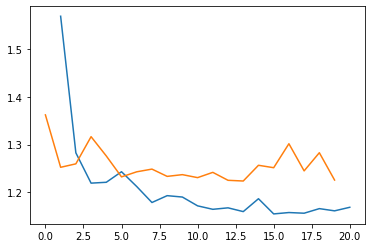

In [21]:
plt.plot(epoch, train_ls, test_ls)

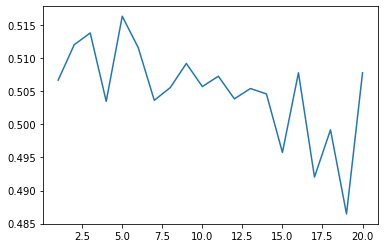

In [22]:
plt.plot(epoch, test_acc)